In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from NObSP_Decomposition import ObSP, NObSP_SVM_single, NObSP_SVM_2order, NObSP_NN_single, NObSP_NN_2order, NObSP_NN_single_MultiOutput, to_categorical
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from Classifier_NN import Classifier_NN
from Classifier_NN_NObSP import Classifier_NN_NObSP
import torch.nn.functional as F
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from sklearn.neighbors import KernelDensity

In [2]:
epochs = 6000 # Definning numebr of epochs to train the models
learning_rate = 0.02 # Defining learning rate of the model

# Loading and preparing input
iris = load_iris()
X = iris.data
y_in = iris.target
names = iris.target_names
p = len(np.unique(y_in))
y_int = y_in.astype(np.int32)
y = to_categorical(y_in, p)
N = np.size(X,0); # Defining the number of datapoints
in_feat = np.size(X,1)

In [3]:
# Input variables
x0 = X[:,0]
x1 = X[:,1]
x2 = X[:,2]
x3 = X[:,3]

t = np.arange(0,N)
train_split = int(0.8*N) # 80% of the data to be used as training

X = torch.from_numpy(X).type(torch.float) # Converting the input matrix to a Pytorch tensor format 
y = torch.from_numpy(y).type(torch.float) # Converting the output data to a Pytorch tensor format 

# Normalizing the input data
X_mean = torch.mean(X,dim=0) 
X_var = torch.var(X,dim=0)
X = (X-X_mean)/X_var

In [4]:
len(X)

150

In [5]:
len(y)

150

In [4]:
# Split of the data for training and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size = train_split,
                                                    random_state=42) 


## Creating model for single nonlinear effects

model_1 = Classifier_NN(in_feat,p) # Creating the model
loss_fcn = nn.CrossEntropyLoss() # Definning loss function
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=learning_rate)  # Defining optimizer

# Training loop for the model 1

In [5]:
for epoch in range(epochs):
    model_1.train() # Setting the model in training mode
    y_prob, x_p, y_lin = model_1(X_train) #forward pass
    
    loss = loss_fcn(y_prob,
                    y_train)  # Compute Loss
    loss.backward() # compute backward
    optimizer.step() # update parameters
    optimizer.zero_grad() #zero grad optimizer
    
    ## Testing
    model_1.eval() # Setting the model in evalaution mode
    with torch.inference_mode():
        y_prob_pred, x_trans, y_lin_pred = model_1(X_test) # Estimating th emodel output in test data
    
    test_loss = loss_fcn(y_prob_pred,
                         y_test) # Evaluating loss
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | test Loss: {test_loss:.5f}') # Printing the performance of the model as it is trained

Epoch: 0 | Loss: 1.09477 | test Loss: 1.09187
Epoch: 100 | Loss: 0.80057 | test Loss: 0.77325
Epoch: 200 | Loss: 0.74747 | test Loss: 0.70316
Epoch: 300 | Loss: 0.72235 | test Loss: 0.67314
Epoch: 400 | Loss: 0.70208 | test Loss: 0.65298
Epoch: 500 | Loss: 0.68367 | test Loss: 0.63771
Epoch: 600 | Loss: 0.66739 | test Loss: 0.62644
Epoch: 700 | Loss: 0.65382 | test Loss: 0.61864
Epoch: 800 | Loss: 0.64288 | test Loss: 0.61275
Epoch: 900 | Loss: 0.63415 | test Loss: 0.60793
Epoch: 1000 | Loss: 0.62643 | test Loss: 0.60402
Epoch: 1100 | Loss: 0.61926 | test Loss: 0.60041
Epoch: 1200 | Loss: 0.61418 | test Loss: 0.59709
Epoch: 1300 | Loss: 0.61018 | test Loss: 0.59459
Epoch: 1400 | Loss: 0.60692 | test Loss: 0.59256
Epoch: 1500 | Loss: 0.60424 | test Loss: 0.59081
Epoch: 1600 | Loss: 0.60200 | test Loss: 0.58931
Epoch: 1700 | Loss: 0.60007 | test Loss: 0.58799
Epoch: 1800 | Loss: 0.59840 | test Loss: 0.58682
Epoch: 1900 | Loss: 0.59693 | test Loss: 0.58578
Epoch: 2000 | Loss: 0.59564 | te

In [6]:
model_1.eval() # Setting the model in evaluation mode
with torch.inference_mode():
    y_prob_1, x_trans_total_1, y_est_1 = model_1(X) # Computin ght enonlinear transformation of the input data X

P_xy_1, y_e_1, Alpha_NN_1 = NObSP_NN_single_MultiOutput(X, y_est_1, model_1) # Computing the decomposition iusing NObSP. The Alpha parameters are the weigths for the Interpretation Layer

y_e_Alpha_1 = np.zeros((N,in_feat,p))
for i in range(p):
    y_e_Alpha_1[:,:,i] = (x_trans_total_1@Alpha_NN_1[:,i*in_feat:i*in_feat+in_feat]) # Computing the decomposition using the Alpha coefficients, out-of-sample extension

y_e_1 = y_e_1.cpu()

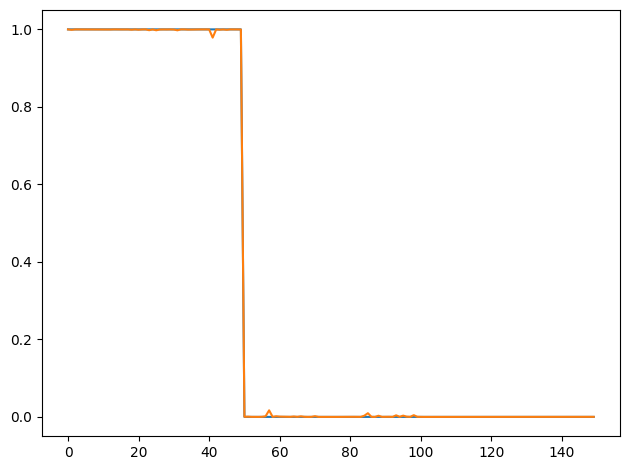

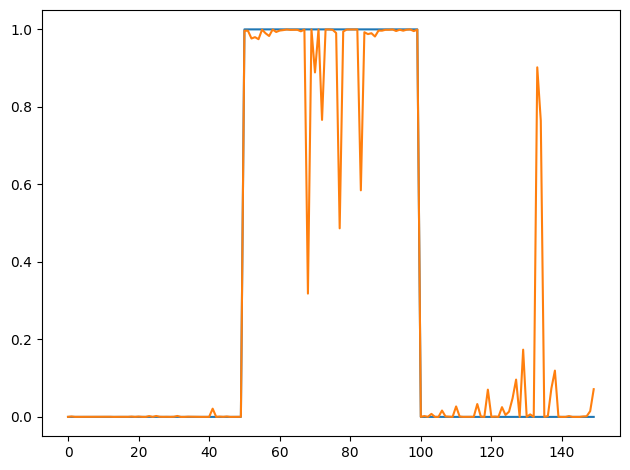

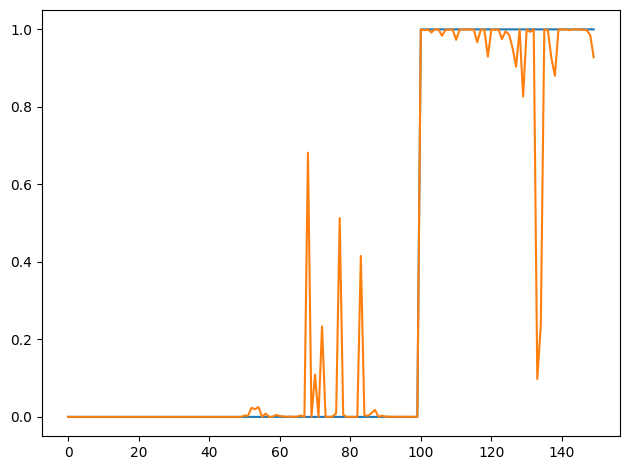

In [7]:
## Plotting the resutls
for i in range(p):
    plt.plot(t,y[:,i],t,y_prob_1[:,i]) # Estimated output vs real output
    plt.tight_layout()
    plt.show()

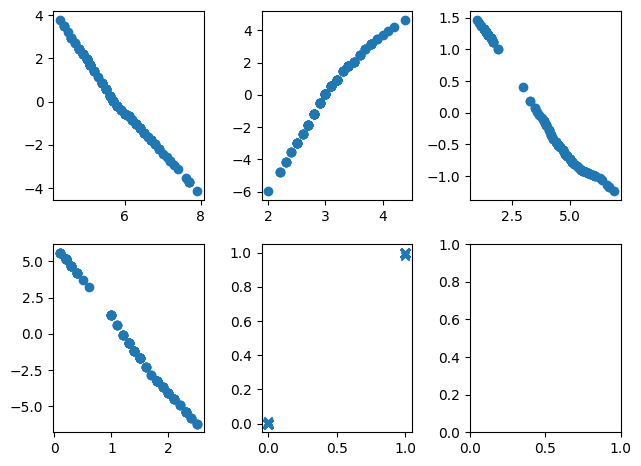

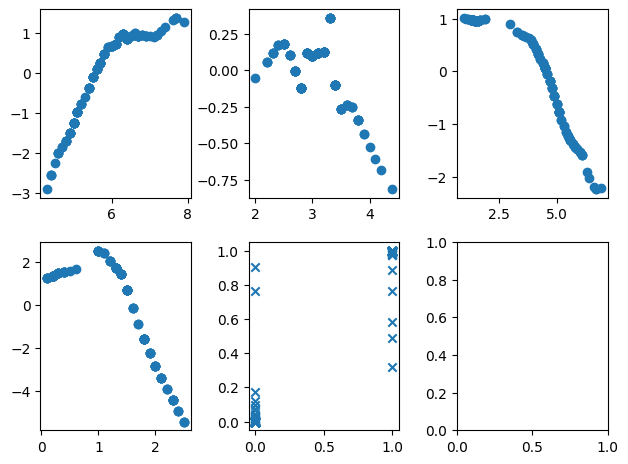

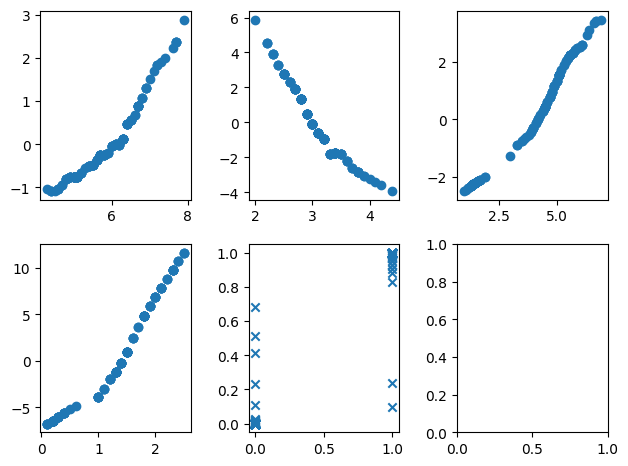

In [8]:
# Plotting the decomposition
for i in range(p):
    fig, axs = plt.subplots(2,3)
    plt.tight_layout()
    axs[0,0].scatter(x0,y_e_1[:,0,i]-y_e_1[:,0,i].mean(),marker='o') # Estimated nonlinear contribution of x0 on the output
    axs[0,1].scatter(x1,y_e_1[:,1,i]-y_e_1[:,1,i].mean(),marker='o') # Estimated nonlinear contribution of x1 on the output
    axs[0,2].scatter(x2,y_e_1[:,2,i]-y_e_1[:,2,i].mean(),marker='o') # Estimated nonlinear contribution of x2 on the output
    axs[1,0].scatter(x3,y_e_1[:,3,i]-y_e_1[:,3,i].mean(),marker='o') # Estimated nonlinear contribution of x3 on the output
    axs[1,1].scatter(y[:,i].cpu(),y_prob_1[:,i].cpu(), marker='x') # Calinbration plot real output vs estiamted output
    plt.show()

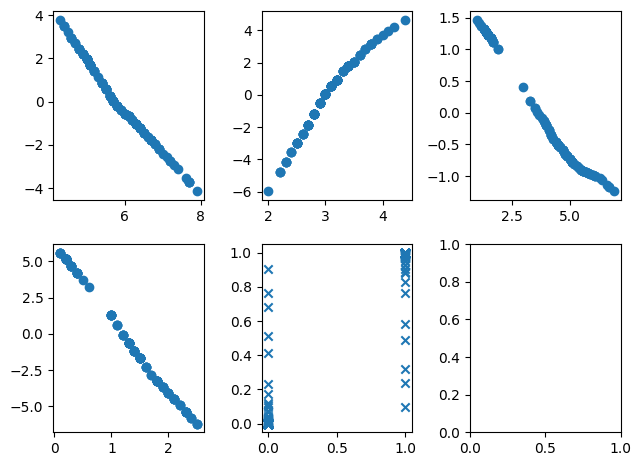

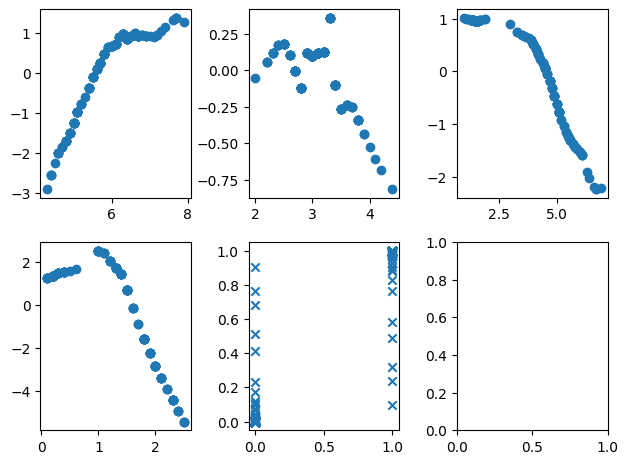

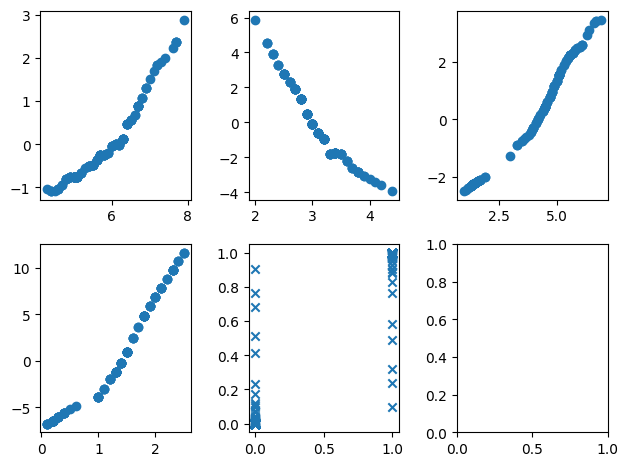

In [9]:
for i in range(p):
    fig, axs = plt.subplots(2,3)
    plt.tight_layout()
    axs[0,0].scatter(x0,y_e_Alpha_1[:,0,i]-y_e_Alpha_1[:,0,i].mean(),marker='o') # Estimated nonlinear contribution of x0 on the output
    axs[0,1].scatter(x1,y_e_Alpha_1[:,1,i]-y_e_Alpha_1[:,1,i].mean(),marker='o') # Estimated nonlinear contribution of x1 on the output
    axs[0,2].scatter(x2,y_e_Alpha_1[:,2,i]-y_e_Alpha_1[:,2,i].mean(),marker='o') # Estimated nonlinear contribution of x2 on the output
    axs[1,0].scatter(x3,y_e_Alpha_1[:,3,i]-y_e_Alpha_1[:,3,i].mean(),marker='o') # Estimated nonlinear contribution of x3 on the output
    axs[1,1].scatter(y.cpu(),y_prob_1.cpu(), marker='x') # Calinbration plot real output vs estiamted output
    plt.show()

In [10]:
Alpha_out_layer = torch.zeros(in_feat*p,p).type(torch.float)
b_out_layer = torch.zeros(1,p)

for i in range(p):
    X_final_1 = torch.cat((torch.from_numpy(y_e_Alpha_1[:,:,i]).squeeze(), torch.ones(N,1)),dim=1) # Extending the matrix of the estimated contributions with a vector of ones to find te value of the bias term

    # Solving the least squares problem between the output of the interpretation layer, and the real output. Ideally 
    # the weigths for this layer should be all 1. However, for numerical errors and to correct for a possible deviation by an scalar 
    # the least square problem is solved.

    Sol = torch.linalg.lstsq(X_final_1.type(torch.float),y_est_1[:,i], rcond=None, driver='gelsd')[0] 
    Alpha_out_layer[i*in_feat:i*in_feat+in_feat,i] = torch.t(Sol[:-1]) # Extracting the weigths for the output layer
    b_out_layer[0,i]= Sol[-1] # Extracting the bias for the output layer

In [11]:
# Creating the model with the interpretable layer. This model uses the model where the data was trained, but it adds an 
# Interpretable layer between the last hidden layer and the output layer of the model. The weigths fo rthe interpretable layer 
# are the coefficients Alpha_NN_1, the bias term are set to 0. The last layer has as weigths the parameters Alpha_out_layer 
# and its bias term b_out_layer

model_1_Inter = Classifier_NN_NObSP(model_1, torch.t(Alpha_NN_1), torch.t(Alpha_out_layer), b_out_layer,p) # Creating the Interpretable model
print(f'The bias per class are: {b_out_layer}')

# Evalauting the model   
model_1_Inter.eval() # Setting th emodel in evaluation mode
with torch.inference_mode():
    y_est_1_Inter, y_est_1_Inter_dec = model_1_Inter(X) # Computing th eoutput of the Interpretable model, the estimated final output and the decomposition


The bias per class are: tensor([[-0.3645,  2.0246, -1.6336]])


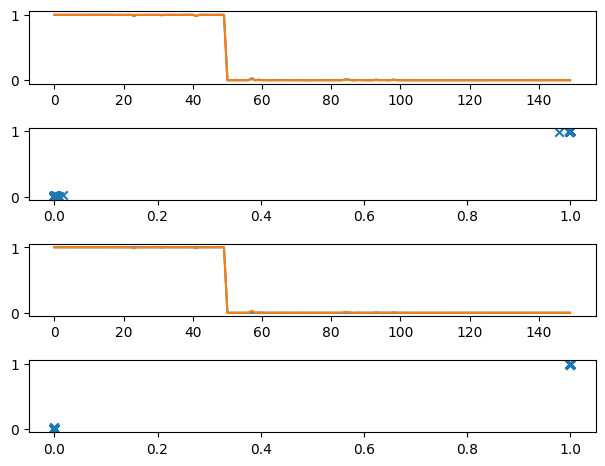

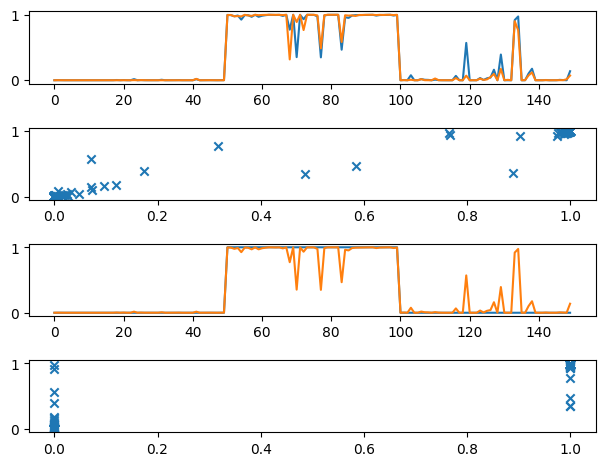

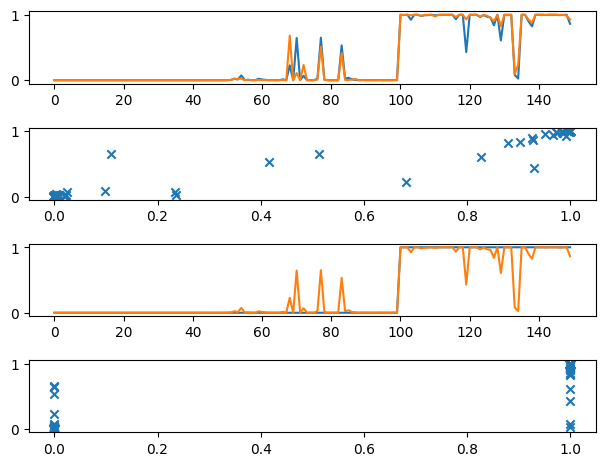

In [12]:
# Plotting the results for the estimated output
for i in range(p):
    
    fig, axs = plt.subplots(4,1)
    plt.tight_layout()
    axs[0].plot(t, y_est_1_Inter[:,i].cpu(), t, y_prob_1[:,i].cpu())  # Estimated output of the interpretable model vs the original model
    axs[1].scatter(y_prob_1[:,i].cpu(), y_est_1_Inter[:,i].cpu(), marker='x')  # Calibration plot between estimated output of the original model vs estimated output of the Interpretable model
    axs[2].plot(t, y[:,i], t, y_est_1_Inter[:,i].cpu()) # Estimated output of the interpretable model vs real output
    axs[3].scatter(y[:,i], y_est_1_Inter[:,i].cpu(), marker='x') # Calibration plot between estimated output of the Interpretable model vs real output
    plt.show()

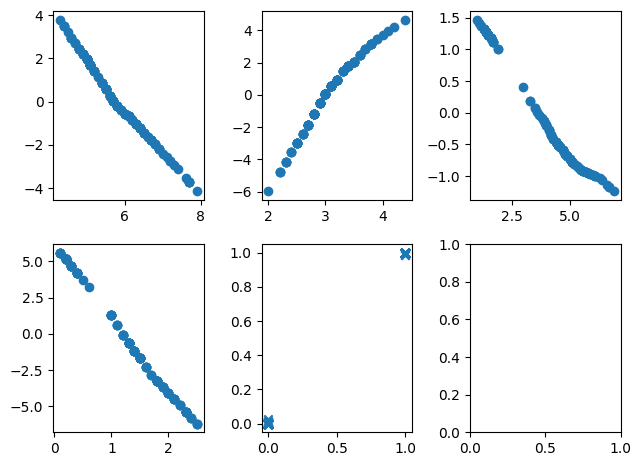

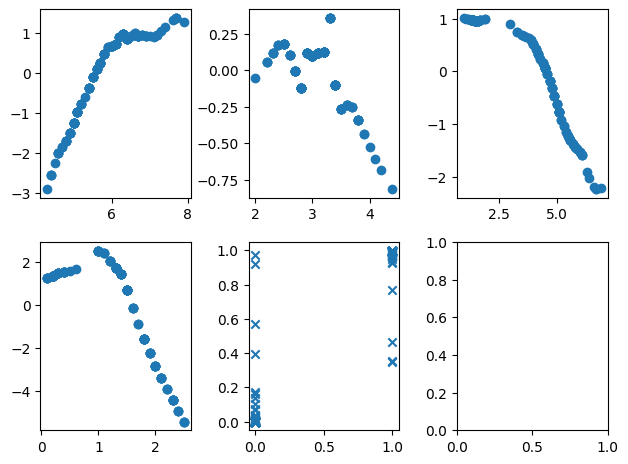

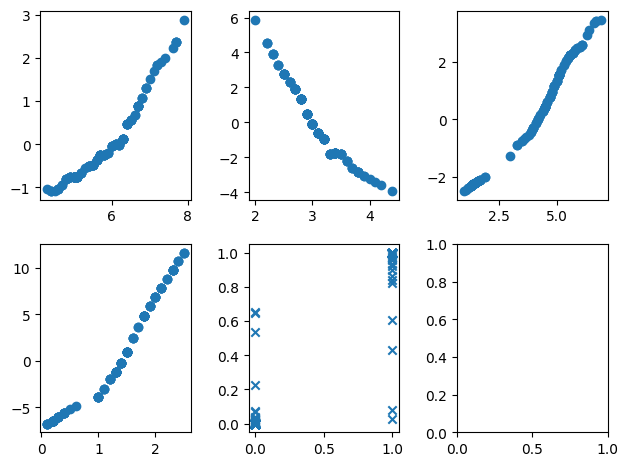

In [13]:
# Plotting the results for the estimated decomposition real and using the model
for i in range(p):
    
    fig, axs = plt.subplots(2,3)
    plt.tight_layout()
    axs[0,0].scatter(x0,y_est_1_Inter_dec[:,i*in_feat+0]-y_est_1_Inter_dec[:,i*in_feat+0].mean(),marker='o') # Estimated nonlinear contribution of x0 on the output
    axs[0,1].scatter(x1,y_est_1_Inter_dec[:,i*in_feat+1]-y_est_1_Inter_dec[:,i*in_feat+1].mean(),marker='o') # Estimated nonlinear contribution of x1 on the output
    axs[0,2].scatter(x2,y_est_1_Inter_dec[:,i*in_feat+2]-y_est_1_Inter_dec[:,i*in_feat+2].mean(),marker='o') # Estimated nonlinear contribution of x2 on the output
    axs[1,0].scatter(x3,y_est_1_Inter_dec[:,i*in_feat+3]-y_est_1_Inter_dec[:,i*in_feat+3].mean(),marker='o') # Estimated nonlinear contribution of x3 on the output
    axs[1,1].scatter(y[:,i].cpu(),y_est_1_Inter[:,i].cpu(), marker='x') # Calinbration plot real output vs estiamted output
    plt.show()

In [14]:
# Estimation error in the projections

error_Model = torch.zeros((N,p))
error_Model_Approx = torch.zeros((N,p))
error_Approx = torch.zeros((N,p))

for i in range(p):
    error_Model[:,i] = y[:,i]-y_prob_1[:,i]
    error_Model_Approx[:,i] = y[:,i]-y_est_1_Inter[:,i]
    error_Approx [:,i]= y_prob_1[:,i]-y_est_1_Inter[:,i]

<Figure size 640x480 with 0 Axes>

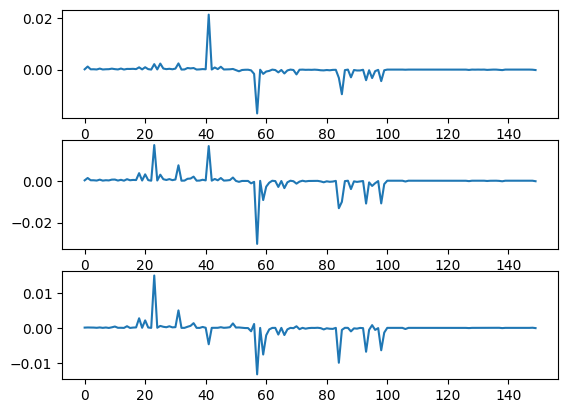

<Figure size 640x480 with 0 Axes>

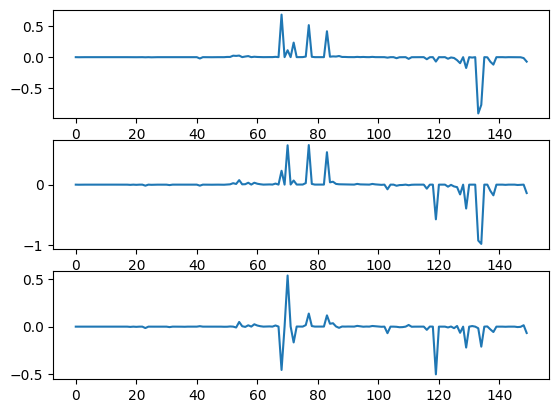

<Figure size 640x480 with 0 Axes>

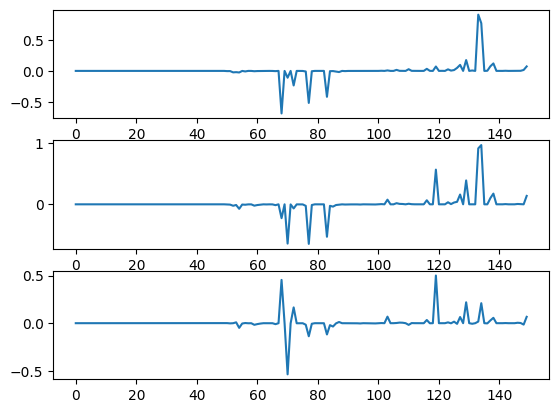

In [15]:
# Plotting the errors
for i in range(p):
    plt.tight_layout()
    fig, axs = plt.subplots(3,1)
    axs[0].plot(error_Model[:,i])
    axs[1].plot(error_Model_Approx[:,i])
    axs[2].plot(error_Approx[:,i])
    plt.show()

In [16]:
Mag_error_Model = np.zeros((p,1))
Mag_error_Model_Approx = np.zeros((p,1))
Mag_error_Approx = np.zeros((p,1))

for i in range(p):
    
    Mag_error_Model[i] = torch.dot(error_Model[:,i].squeeze(),error_Model[:,i].squeeze())/N
    Mag_error_Model_Approx[i] = torch.dot(error_Model_Approx[:,i].squeeze(),error_Model_Approx[:,i].squeeze())/N
    Mag_error_Approx[i] = torch.dot(error_Approx[:,i].squeeze(),error_Approx[:,i].squeeze())/N

    print(f'The error in the prediction of the original model for the output y{i} is: {Mag_error_Model[i]}')
    print(f'The error in the prediction of the interpretable model for the output y{i} is: {Mag_error_Model_Approx[i]}')
    print(f'The error between the predictions of the original and the interpretable model for the output y{i} is: {Mag_error_Approx[i]}')

The error in the prediction of the original model for the output y0 is: [6.23319283e-06]
The error in the prediction of the interpretable model for the output y0 is: [1.49537218e-05]
The error between the predictions of the original and the interpretable model for the output y0 is: [4.85343162e-06]
The error in the prediction of the original model for the output y1 is: [0.01629277]
The error in the prediction of the interpretable model for the output y1 is: [0.02380402]
The error between the predictions of the original and the interpretable model for the output y1 is: [0.00614329]
The error in the prediction of the original model for the output y2 is: [0.01628426]
The error in the prediction of the interpretable model for the output y2 is: [0.02376505]
The error between the predictions of the original and the interpretable model for the output y2 is: [0.0061361]
